In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex
from scipy.optimize import least_squares

In [2]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [16]:
alpha = 5
c1s   = np.arange(1, 5.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. ])

In [28]:
guesses = c1s

xTildes  = []
welfares = [] 
bids     = []
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    cBids   = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(cBids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
    bids.append(cBids)
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
bids     = np.asarray(bids)
xTildes.shape, welfares.shape, bids.shape

((41, 2), (41,), (41, 2))

In [18]:
def explicitQuadraticRoot(c, a):
    # Calculate coefficients
    A = (1 - c) * a**2 - 2 * a
    B = c * a * (a - 1) + 2 - a**2
    C = a - 1
    
    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    
    # Compute square root of discriminant
    sqrt_discriminant = math.sqrt(discriminant)
    
    # Compute the positive root using the quadratic formula
    x_star = (-B - sqrt_discriminant) / (2 * A)
    
    return x_star

In [24]:
explicitQuadraticRoot(c=5, a=3)

0.6239390754726843

1. bound low cost allo below and high cost allo above
2. use 2 eq 2 unkowns to solve for equil bids (up to constant)
3. find constant such that it equals the bid when cost is 1.
4. check that bounds are negative in the SOC

In [25]:
def invAllos(x, a):
    return (x/(1-x))**(1/a)

In [44]:
invAllos(0.6239390754726843, a=3)

1.1838444938556116

In [33]:
def socSign(a, b, c, o):
    return (c+b+a*(b-c)) + o*b**a * (c+b+a*(c-b))

In [34]:
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. ])

In [41]:
p1socs = []
p2socs = []
for i, c1 in enumerate(c1s):
    p1socs.append(socSign(a=3, b=bids[i,0], c=1, o=bids[i,1]**(-3)))
    p2socs.append(socSign(a=3, b=bids[i,1], c=c1, o=bids[i,0]**(-3)))

In [42]:
p2socs

[5.3333333333332344,
 5.802215876041792,
 6.3020472659860305,
 6.826963707824916,
 7.371975865987982,
 7.933012694512142,
 8.506833796633284,
 9.090893467442232,
 9.683202141040876,
 10.282204918595397,
 10.88668256919832,
 11.49567390988246,
 12.10841617298726,
 12.724299647323065,
 13.342833285010839,
 13.963618607323486,
 14.586329840789022,
 15.210698721970019,
 15.83650280522675,
 16.463556407873156,
 17.091703550589898,
 17.720812415830522,
 18.350770968285985,
 18.981483470140297,
 19.612867691428523,
 20.244852660809798,
 20.87737684280903,
 21.51038665095773,
 22.143835228433502,
 22.777681440540896,
 23.411889051691396,
 24.046426010459413,
 24.681263889646814,
 25.316377387182733,
 25.95174391600489,
 26.587343254373675,
 27.223157248214086,
 27.859169556815555,
 28.495365434677954,
 29.131731543797148,
 29.768255791556655]

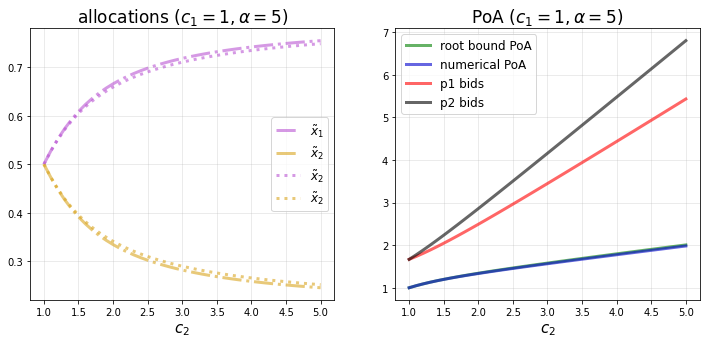

In [32]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')
roots = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])
axarr[0].plot(c1s, roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='mediumorchid',
              linestyle='dotted')
axarr[0].plot(c1s, 1-roots, linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='dotted')



axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')
axarr[1].plot(c1s, bids[:,0], linewidth=3, alpha=0.6, label='p1 bids', color='red')
axarr[1].plot(c1s, bids[:,1], linewidth=3, alpha=0.6, label='p2 bids', color='black')
# axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='p1', color='mediumblue')
# axarr[1].plot(c1s, invAllos(roots))


for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()